In [7]:
import glob
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as tc
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numba
from tqdm import tqdm
from tqdm import trange

warnings.filterwarnings(action='ignore')


In [8]:
def get_dataframe_from_dir(path, ext, ignore_idx=False, save_file=False):
    df = pd.DataFrame()
    if ext != 'csv':
        return df
    
    csv_files = glob.glob(path + f"/*.{ext}")
    df_list = (pd.read_csv(file) for file in csv_files)
    get_next = peek(df_list)

    if get_next is None:
        print("***** empty dataframe *****")
        return df
    
    df = pd.concat(df_list, ignore_index=ignore_idx)
    if save_file:
        df.to_csv('merged.csv')
    if 'time' in df.columns:
        df.set_index("time", drop=True, append=False, inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    else:
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    
    return df


def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable)

In [18]:
df = get_dataframe_from_dir("../__data__/xaiops_metric/was/214(04.01~07.10)", "csv", save_file=True)
# df = df.sample(frac=0.01)

# remove low variance column
for column in df.columns:
    if df[column].mean() == 0:
        df.drop(columns=[column], inplace=True)

# remove rows having NaN value
df.dropna(axis=0, inplace=True)

# sort index
df.sort_index(inplace=True)


In [20]:
143908 * 80 // 100

df_train = df.iloc[:len(df)*80//100, :]
df_test = df.iloc[len(df)*80//100:, :]
df_train
df_test


,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
time,,,,,,,,,,,,,,,,,,,,,
2022-06-21 00:15:00,0.00,0.00,0.00,0.00,1.5699,0.00,9.0,0.00,0.0,0.0,...,0.00,0.0000,0.00,0.00,0.00,0.00,98.0,0.0000,0.00,0.00
2022-06-21 00:16:00,0.00,0.00,0.00,0.00,1.8649,0.00,9.0,0.00,0.0,0.0,...,0.00,0.0000,0.00,0.00,0.05,0.40,98.0,0.0000,0.05,0.40
2022-06-21 00:17:00,0.00,0.00,0.10,0.10,1.7750,0.00,9.0,0.00,0.0,0.0,...,0.00,1.0000,0.00,0.00,0.00,0.00,98.0,0.0333,0.00,0.00
2022-06-21 00:18:00,0.00,0.00,0.00,0.00,1.5750,0.00,9.0,0.00,0.0,0.0,...,0.00,0.0000,0.00,0.00,0.05,0.15,98.0,0.0000,0.05,0.15
2022-06-21 00:19:00,0.00,0.00,0.10,0.10,1.5450,0.00,9.0,0.00,0.0,0.0,...,0.00,1.0000,0.00,0.00,0.00,0.00,98.0,0.0333,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-10 23:55:00,0.05,2.10,0.50,1.25,2.6850,0.05,9.0,3.15,0.0,0.0,...,7.15,70.7187,7.15,172.00,0.25,1.45,148.5,1.0666,0.25,1.45
2022-07-10 23:56:00,0.10,2.10,0.50,1.25,2.2450,0.05,9.0,3.15,0.0,0.0,...,7.20,60.6153,7.20,142.90,0.25,1.10,148.6,1.0833,0.25,1.10
2022-07-10 23:57:00,0.05,2.05,0.60,1.25,2.9049,0.00,9.0,3.30,0.0,0.0,...,7.45,63.0294,7.45,152.55,0.30,1.50,148.5,1.1333,0.30,1.50


In [23]:
X_train = df.iloc[:, :-1]
X_train

X_test = df_test.iloc[:, :-1]
X_test


,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,os_total_memory,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc
time,,,,,,,,,,,,,,,,,,,,,
2022-06-21 00:15:00,0.00,0.00,0.00,0.00,1.5699,0.00,9.0,0.00,0.0,0.0,...,32641244.0,0.00,0.0000,0.00,0.00,0.00,0.00,98.0,0.0000,0.00
2022-06-21 00:16:00,0.00,0.00,0.00,0.00,1.8649,0.00,9.0,0.00,0.0,0.0,...,32641244.0,0.00,0.0000,0.00,0.00,0.05,0.40,98.0,0.0000,0.05
2022-06-21 00:17:00,0.00,0.00,0.10,0.10,1.7750,0.00,9.0,0.00,0.0,0.0,...,32641244.0,0.00,1.0000,0.00,0.00,0.00,0.00,98.0,0.0333,0.00
2022-06-21 00:18:00,0.00,0.00,0.00,0.00,1.5750,0.00,9.0,0.00,0.0,0.0,...,32641244.0,0.00,0.0000,0.00,0.00,0.05,0.15,98.0,0.0000,0.05
2022-06-21 00:19:00,0.00,0.00,0.10,0.10,1.5450,0.00,9.0,0.00,0.0,0.0,...,32641244.0,0.00,1.0000,0.00,0.00,0.00,0.00,98.0,0.0333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-10 23:55:00,0.05,2.10,0.50,1.25,2.6850,0.05,9.0,3.15,0.0,0.0,...,32641244.0,7.15,70.7187,7.15,172.00,0.25,1.45,148.5,1.0666,0.25
2022-07-10 23:56:00,0.10,2.10,0.50,1.25,2.2450,0.05,9.0,3.15,0.0,0.0,...,32641244.0,7.20,60.6153,7.20,142.90,0.25,1.10,148.6,1.0833,0.25
2022-07-10 23:57:00,0.05,2.05,0.60,1.25,2.9049,0.00,9.0,3.30,0.0,0.0,...,32641244.0,7.45,63.0294,7.45,152.55,0.30,1.50,148.5,1.1333,0.30


In [29]:
Y_train = df.iloc[:, -1:]
Y_train
Y_test = df_test.iloc[:, -1:]
Y_test


,ygct
time,
2022-06-21 00:15:00,0.00
2022-06-21 00:16:00,0.40
2022-06-21 00:17:00,0.00
2022-06-21 00:18:00,0.15
2022-06-21 00:19:00,0.00
...,...
2022-07-10 23:55:00,1.45
2022-07-10 23:56:00,1.10
2022-07-10 23:57:00,1.50


In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca
X_test_pca

array([[-5638994.0048604 ,  -164940.70339792],
       [-5639328.61495751,  -164980.47130283],
       [-5639001.22034299,  -164882.87040746],
       ...,
       [ 8065900.75058049,  -230044.43713157],
       [ 8065615.86650373,  -229931.53757748],
       [ 8066268.47227203,  -229931.4534298 ]])

In [32]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[2.99306156e+13 1.44982681e+11]
[0.99496179 0.00481955]


In [33]:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=['pca_column1', 'pca_column2'])
print(X_train_pca_df)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=['pca_column1', 'pca_column2'])
print(X_test_pca_df)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))


         pca_column1    pca_column2
0       1.454251e+07 -239230.887284
1       1.454128e+07 -240114.691724
2       1.453927e+07 -240081.745493
3       1.453907e+07 -241032.660517
4       1.452112e+07 -241278.236753
...              ...            ...
143903  8.062814e+06 -230131.018759
143904  8.064345e+06 -230085.863302
143905  8.065901e+06 -230044.437132
143906  8.065616e+06 -229931.537577
143907  8.066268e+06 -229931.453430

[143908 rows x 2 columns]
        pca_column1    pca_column2
0     -5.638994e+06 -164940.703398
1     -5.639329e+06 -164980.471303
2     -5.639001e+06 -164882.870407
3     -5.637735e+06 -165080.388453
4     -5.639246e+06 -164817.882289
...             ...            ...
28777  8.062814e+06 -230131.018759
28778  8.064345e+06 -230085.863302
28779  8.065901e+06 -230044.437132
28780  8.065616e+06 -229931.537577
28781  8.066268e+06 -229931.453430

[28782 rows x 2 columns]
[2.99306156e+13 1.44982681e+11]
[0.99496179 0.00481955]
0.9997813404509314


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled)

columns = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns)
X_train_scaled_df

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns)
X_test_scaled_df


[[-0.34907031 -0.14327805 -2.02041194 ...  0.84363507 -1.10031881
  -1.390764  ]
 [-0.40750757 -0.14469196 -2.48315417 ...  0.82267294 -1.10222709
  -1.54150375]
 [-0.40750757 -0.14469196 -2.36746861 ...  0.82034382 -1.04318468
  -1.46613388]
 ...
 [-0.34907031 -0.11499987 -1.21061302 ...  0.10996068 -1.01081248
  -1.08928448]
 [-0.40750757 -0.11641378 -1.09492746 ...  0.10996068 -1.01272076
  -1.16465436]
 [-0.34907031 -0.11217205 -1.32629858 ...  0.10996068 -0.99367224
  -1.01391461]]
[[-0.40750757 -0.17297014 -2.59883973 ... -1.06624745 -1.1403127
  -1.54150375]
 [-0.40750757 -0.17297014 -2.59883973 ... -1.06624745 -1.1403127
  -1.46613388]
 [-0.40750757 -0.17297014 -2.36746861 ... -1.06624745 -1.13650757
  -1.54150375]
 ...
 [-0.34907031 -0.11499987 -1.21061302 ...  0.10996068 -1.01081248
  -1.08928448]
 [-0.40750757 -0.11641378 -1.09492746 ...  0.10996068 -1.01272076
  -1.16465436]
 [-0.34907031 -0.11217205 -1.32629858 ...  0.10996068 -0.99367224
  -1.01391461]]


,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,os_total_memory,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc
0,-0.407508,-0.172970,-2.598840,-1.162697,-0.349272,-1.157027,0.064477,-1.105703,-0.461349,-0.459011,...,0.002636,-1.125602,-0.249596,-1.125602,-0.562966,-1.538759,-1.373642,-1.066247,-1.140313,-1.541504
1,-0.407508,-0.172970,-2.598840,-1.162697,-0.252944,-1.157027,0.064477,-1.105703,-0.461349,-0.459011,...,0.002636,-1.125602,-0.249596,-1.125602,-0.562966,-1.464164,-1.315092,-1.066247,-1.140313,-1.466134
2,-0.407508,-0.172970,-2.367469,-1.151337,-0.282299,-1.157027,0.064477,-1.105703,-0.461349,-0.459011,...,0.002636,-1.125602,-0.248342,-1.125602,-0.562966,-1.538759,-1.373642,-1.066247,-1.136508,-1.541504
3,-0.407508,-0.172970,-2.598840,-1.162697,-0.347607,-1.157027,0.064477,-1.105703,-0.461349,-0.459011,...,0.002636,-1.125602,-0.249596,-1.125602,-0.562966,-1.464164,-1.351686,-1.066247,-1.140313,-1.466134
4,-0.407508,-0.172970,-2.367469,-1.151337,-0.357403,-1.157027,0.064477,-1.105703,-0.461349,-0.459011,...,0.002636,-1.125602,-0.248342,-1.125602,-0.562966,-1.538759,-1.373642,-1.066247,-1.136508,-1.541504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28777,-0.349070,-0.113586,-1.441984,-1.020700,0.014850,-1.123290,0.064477,-0.984029,-0.461349,-0.459011,...,0.002636,-0.999843,-0.160974,-0.999843,-0.423488,-1.165782,-1.161398,0.109961,-1.018434,-1.164654
28778,-0.290633,-0.113586,-1.441984,-1.020700,-0.128826,-1.123290,0.064477,-0.984029,-0.461349,-0.459011,...,0.002636,-0.998964,-0.173635,-0.998964,-0.447086,-1.165782,-1.212629,0.112290,-1.016526,-1.164654
28779,-0.349070,-0.115000,-1.210613,-1.020700,0.086656,-1.157027,0.064477,-0.978235,-0.461349,-0.459011,...,0.002636,-0.994567,-0.170610,-0.994567,-0.439260,-1.091186,-1.154079,0.109961,-1.010812,-1.089284
28780,-0.407508,-0.116414,-1.094927,-1.020700,-0.177840,-1.157027,0.064477,-0.982098,-0.461349,-0.459011,...,0.002636,-0.996325,-0.151269,-0.996325,-0.399971,-1.165782,-1.190673,0.109961,-1.012721,-1.164654


In [37]:
variances = []
exp_var_ratios = []
train_datas = []
test_datas = []
pca_instances = []
for i in range(2, 9):
    print('original components count: ', X_train.shape[1])
    print('n_components: ', i)
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_scaled_df)
    X_test_pca = pca.transform(X_test_scaled_df)
    train_datas.append(X_train_pca)
    test_datas.append(X_test_pca)
    
    variances.append(np.mean(pca.explained_variance_))
    exp_var_ratios.append(np.sum(pca.explained_variance_ratio_))

    pca_instances.append(pca)

print('vars: ', variances)
print('explained variance ratio: ', exp_var_ratios)


original components count:  31
n_components:  2
original components count:  31
n_components:  3
original components count:  31
n_components:  4
original components count:  31
n_components:  5
original components count:  31
n_components:  6
original components count:  31
n_components:  7
original components count:  31
n_components:  8
vars:  [9.17900841045978, 7.15023736102835, 5.829837808377493, 4.878401658831055, 4.242168948018933, 3.7847536305255924, 3.4296564710482964]
explained variance ratio:  [0.5921899759093561, 0.6919536459540283, 0.7522319093562287, 0.786833509578029, 0.8210592521959291, 0.8546158488703637, 0.8850664874227843]


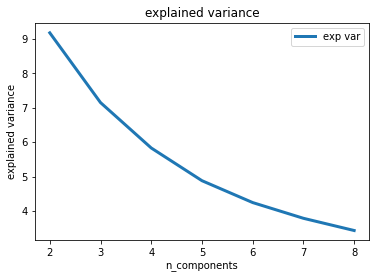

In [38]:
plt.plot(np.arange(2, len(variances) + 2), variances, linewidth=3)
plt.title('explained variance')
plt.xlabel('n_components')
plt.ylabel('explained variance')
plt.legend(['exp var'])
plt.show()

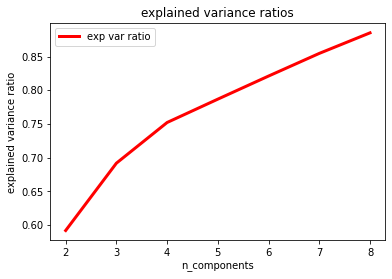

In [39]:
plt.plot(np.arange(2, len(variances) + 2), exp_var_ratios, c='red', linewidth=3)
plt.title('explained variance ratios')
plt.xlabel('n_components')
plt.ylabel('explained variance ratio')
plt.legend(['exp var ratio'])
plt.show()